# **Load necessary package**

In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib as matlib 
import matplotlib.pyplot as plt 
import seaborn as sns 

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,None,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# **Loading data**
#### Set file path
#### Load in CSV (2020, 2021, 2022)

In [2]:
# Set a path to your drive  

# my data is stored in "nfldata/pbp"
project_dir = "jupyter_workspace"

# You can explore the different folders using 
# `os.listdir()`
szn_folders = os.listdir(f"{project_dir}/nfldata/pbp")
print(szn_folders)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['2022', '2023', '.DS_Store', '2019', '2021', '2020', '2018']

In [3]:
# Within each season folder is a play-by-play CSV
# We'll need this to create our ML model 
# Let's just take seasons 2020-2022:  
target_seasons = [x for x in szn_folders 
                  if ('2020' in x) | 
                  ('2021' in x) | 
                  ('2022' in x)]

# This list comprehension navigates to the season 
# folder and selects the play-by-play filename and 
# appends it to a full path name
data_files = ([f"""{project_dir}/nfldata/pbp/{data_folder}/{os.listdir(f"{project_dir}/nfldata/pbp/{data_folder}")[0]}""" 
               for data_folder in target_seasons])

print(data_files)
     

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['jupyter_workspace/nfldata/pbp/2022/play_by_play_2022.csv', 'jupyter_workspace/nfldata/pbp/2021/play_by_play_2021.csv', 'jupyter_workspace/nfldata/pbp/2020/play_by_play_2020.csv']

In [4]:
# We can open these data with pandas in a for loop

# initialize a dataframe to append data into
df = pd.DataFrame()

# loop through your filenames, open them, 
# and concat them to the df 
for fn in data_files: 
  df = pd.concat([df,pd.read_csv(fn,low_memory=False)])

# reset the index; each CSV comes in with its own
# index which causes duplicate indicies in a load
# like this 
df = df.reset_index(drop=True)  

# print the size of the dataframe
print(df.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(149373, 372)

In [5]:
# show the top 10 results
df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   play_id          game_id  old_game_id  ...   xyac_fd     xpass    pass_oe
0        1  2022_01_BAL_NYJ   2022091107  ...       NaN       NaN        NaN
1       43  2022_01_BAL_NYJ   2022091107  ...       NaN       NaN        NaN
2       68  2022_01_BAL_NYJ   2022091107  ...       NaN  0.440373 -44.037291
3       89  2022_01_BAL_NYJ   2022091107  ...  0.227598  0.389904  61.009598
4      115  2022_01_BAL_NYJ   2022091107  ...       NaN  0.443575 -44.357494
5      136  2022_01_BAL_NYJ   2022091107  ...       NaN  0.963242   3.675753
6      172  2022_01_BAL_NYJ   2022091107  ...       NaN       NaN        NaN
7      202  2022_01_BAL_NYJ   2022091107  ...  0.241949  0.479318  52.068213
8      230  2022_01_BAL_NYJ   2022091107  ...  0.514376  0.608057  39.194345
9      254  2022_01_BAL_NYJ   2022091107  ...       NaN  0.798116 -79.811603

[10 rows x 372 columns]

In [6]:
# show a random sample of 5 rows 
df.sample(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        play_id          game_id  old_game_id  ...   xyac_fd     xpass    pass_oe
76260      3077  2021_10_MIN_LAC   2021111408  ...       NaN  0.609165 -60.916549
42608      3001  2022_17_ARI_ATL   2023010100  ...       NaN  0.470622 -47.062209
99560      3051   2021_19_SF_DAL   2022011601  ...  0.295410  0.755532  24.446803
119325     1293  2020_07_SEA_ARI   2020102508  ...       NaN  0.478389 -47.838917
2647       2596   2022_01_SF_CHI   2022091102  ...  0.498949  0.524593  47.540748

[5 rows x 372 columns]

In [7]:
# list all columns in the dataframe 
# df.columns.values

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## **Explore features**
#### What correlates with touchdowns?
#### Use yards and previous season performance to predict touchdowns?

In [82]:
# Although this dataset has a lot of different
# features, you most likely don't need to use
# all of them to create your first predictive 
# model. We should start simple with things that
# correlate with quarterback touchdowns 

# Let's take some basic quarterback stats 
qb_feats = ['season', 'passer_id', 'passer', 'pass', 
            'complete_pass', 'interception', 
            'sack', 'yards_gained', 'touchdown']

# Let's group by season and who the passer was 
groupby_feats = ['season', 'passer_id', 'passer'] 

# group by and aggregate by sum 
qb_df = (df
         .loc[:, qb_feats]
         .groupby(groupby_feats, 
                  as_index=False)
         .sum())

# random sample of 10 player-seasons 
qb_df.sample(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id       passer  ...  sack  yards_gained  touchdown
288    2022  00-0033319    N.Mullens  ...   0.0         230.0        1.0
129    2021  00-0026197      C.Henne  ...   0.0          86.0        0.0
332    2022  00-0036322  J.Jefferson  ...   0.0          40.0        0.0
212    2021  00-0035228     K.Murray  ...  33.0        3847.0       28.0
210    2021  00-0035040     D.Blough  ...   1.0           0.0        0.0
300    2022  00-0033949      J.Dobbs  ...   6.0         408.0        3.0
214    2021  00-0035544    T.Kennedy  ...   0.0          75.0        1.0
60     2020  00-0033077   D.Prescott  ...  10.0        1856.0       10.0
264    2022  00-0030288   R.Burkhead  ...   0.0           0.0        0.0
30     2020  00-0029604    K.Cousins  ...  39.0        4157.0       37.0

[10 rows x 9 columns]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

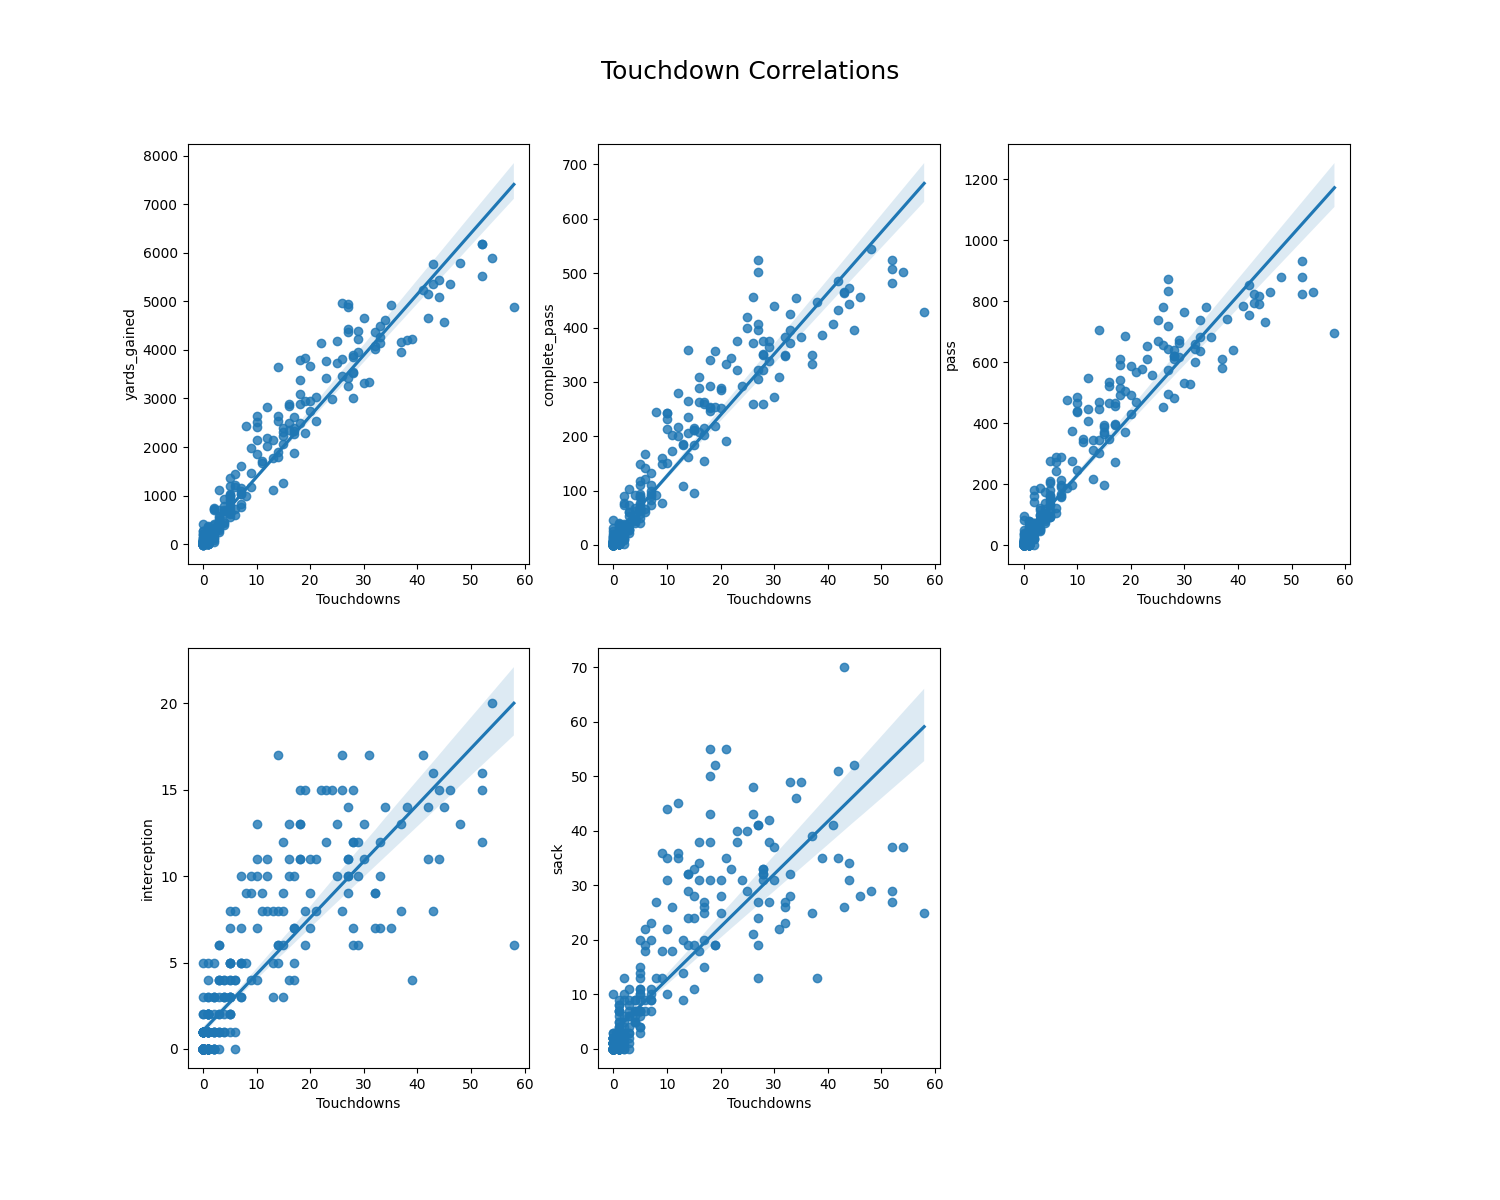

In [83]:
# let's see what correlates with touchdowns 
# list of columns we think correlate to TDs
correlators = ['yards_gained', 'complete_pass', 'pass', 'interception', 'sack']
# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown Correlations", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 3
# calculate number of rows
nrows = len(correlators) // ncols + (len(correlators) % ncols > 0)

# loop through the length of our correlators and keep track of index
for n, correlation in enumerate(correlators):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)
    # plot our data
    sns.regplot(data=qb_df, x='touchdown', y=correlation)
    # chart formatting
    # ax.set_title("Touchdowns & " + correlation.upper())
    ax.set_xlabel("Touchdowns")
%matplot plt

In [84]:
# Apparently knowing yards gained, 
# completed passes, attempted passes, 
# interceptions, and sacks all correlate with
# touchdowns. Let's see if this is the case for
# _next season_ touchdowns 

# make a copy of the qb dataframe 
_df = qb_df.copy()

# add 1 to season
_df['season'] = _df['season'].add(1)

# merge this back on the original qb dataframe
# specify "on=[]" so we only join on specific 
# columns; specify "suffixes=()" so the duplicate
# column names get a suffix appended to them; 
# specify "how='left'" so this is a left join 
new_qb_df = (qb_df
             .merge(_df, 
                    on=['season', 'passer_id', 'passer'], 
                    suffixes=('', '_prev'), 
                    how='left'))

new_qb_df.sample(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id  ... yards_gained_prev  touchdown_prev
160    2021  00-0031395  ...             246.0             1.0
51     2020  00-0032009  ...               NaN             NaN
192    2021  00-0034052  ...               NaN             NaN
13     2020  00-0026498  ...               NaN             NaN
320    2022  00-0035289  ...             427.0             4.0
2      2020  00-0022824  ...               NaN             NaN
54     2020  00-0032436  ...               NaN             NaN
257    2022  00-0027973  ...            1458.0             9.0
212    2021  00-0035228  ...            4216.0            29.0
110    2020  00-0036142  ...               NaN             NaN

[10 rows x 15 columns]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

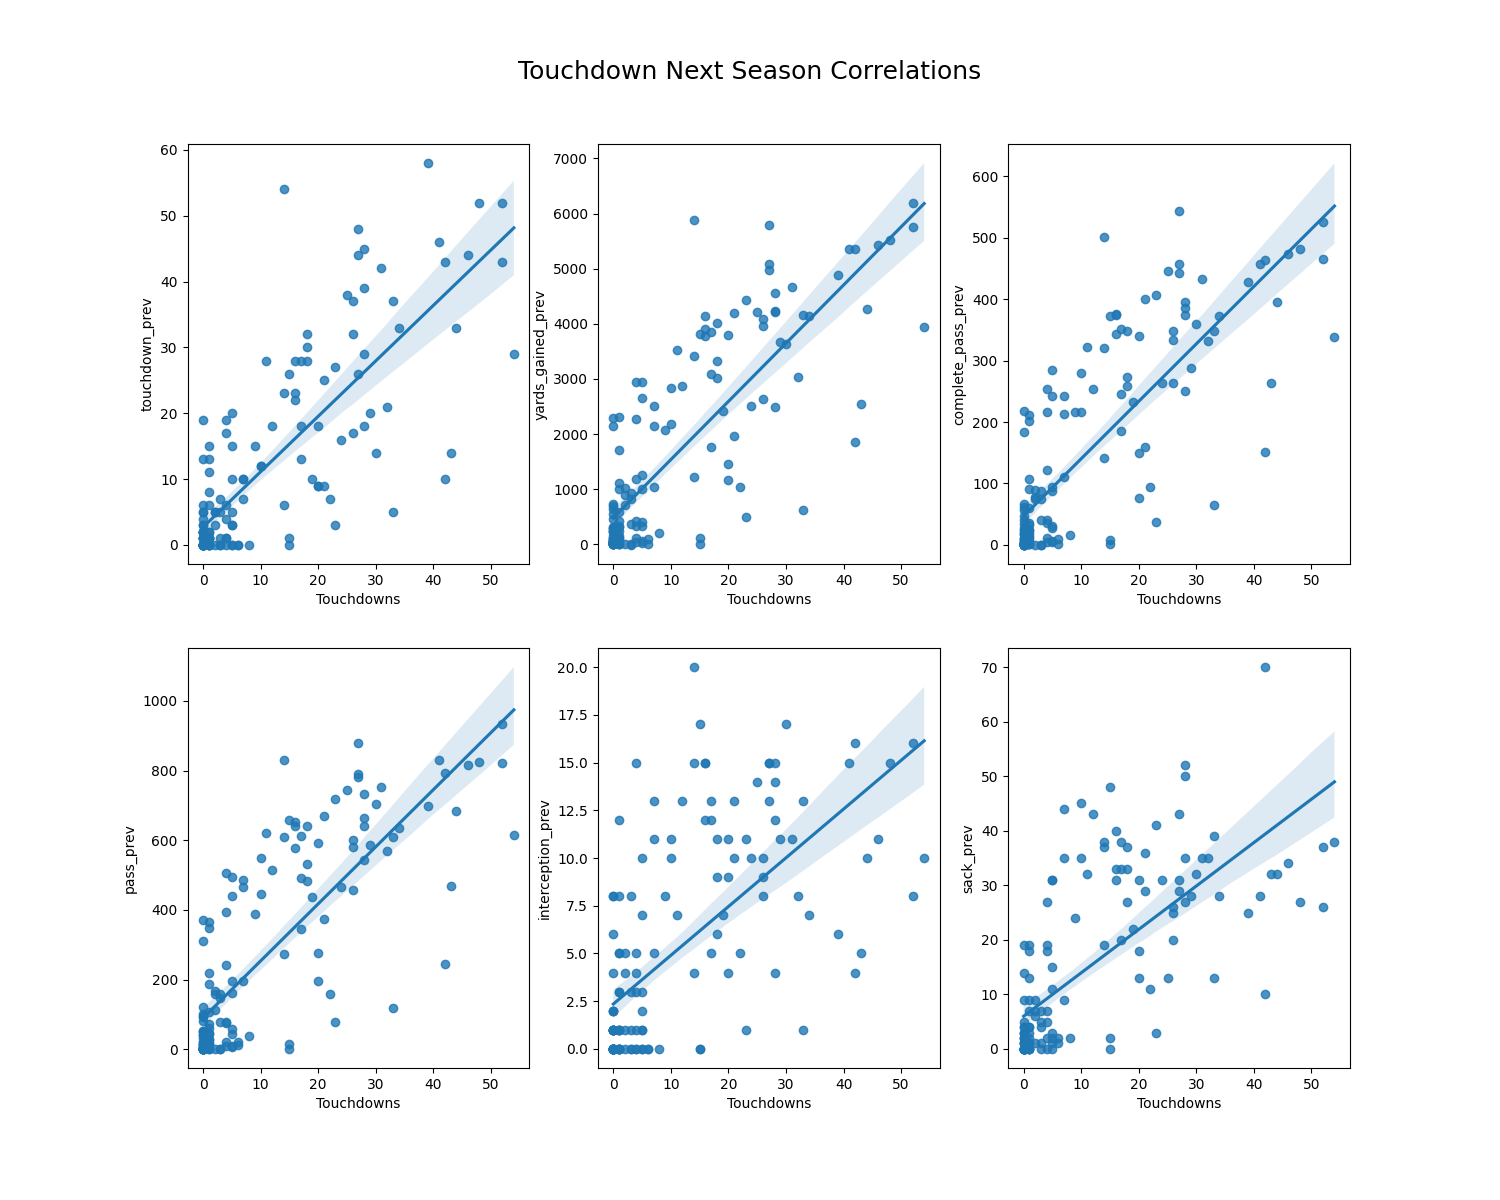

In [85]:
# let's see what correlates with next season touchdowns
# list of columns we think correlate to TDs
correlators = ['touchdown_prev','yards_gained_prev', 'complete_pass_prev', 'pass_prev', 'interception_prev','sack_prev']
# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown Next Season Correlations", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 3
# calculate number of rows
nrows = len(correlators) // ncols + (len(correlators) % ncols > 0)

# loop through the length of our correlators and keep track of index
for n, correlation in enumerate(correlators):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)
    # plot our data
    sns.regplot(data=new_qb_df, x='touchdown', y=correlation)
    # chart formatting
    # ax.set_title("Touchdowns & " + correlation.upper())
    ax.set_xlabel("Touchdowns")
%matplot plt

## **Machine Learning**
    * Simple Linear Model
    * Train with the previous year, test on the next year
    * Save out-of-sample-results
    * Visualize and run basic stats

#### Using previous season information, we can see 
#### there are year-to-year correlations with
#### touchdowns. Let's use previous season performance
#### to estimate touchdowns thrown for the next season

In [68]:
# Let's load in machine learning and stats packages
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
new_qb_df.sample(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id  ... yards_gained_prev  touchdown_prev
162    2021  00-0031543  ...               NaN             NaN
196    2021  00-0034401  ...               NaN             NaN
152    2021  00-0030578  ...               NaN             NaN
132    2021  00-0026625  ...             120.0             0.0
160    2021  00-0031395  ...             246.0             1.0
67     2020  00-0033466  ...               NaN             NaN
353    2022  00-0037740  ...               NaN             NaN
336    2022  00-0036389  ...            3668.0            20.0
250    2022  00-0026197  ...              86.0             0.0
23     2020  00-0028002  ...               NaN             NaN

[10 rows x 15 columns]

In [87]:
# We will "train" our data on one season and "test"
# on the next season. If you are unfamiliar with
# the concept of train test splitting, I suggest 
# codebasics tutorial https://www.youtube.com/watch?v=fwY9Qv96DJY

# Let's use the previous season performance as
# our features for our model 
features = ['pass_prev', 'complete_pass_prev', 
            'interception_prev', 'sack_prev',
            'yards_gained_prev',
            'touchdown_prev']

# We are predicting "current" season touchdowns 
target = 'touchdown' 

# Let's make a subset of data that has 
# no null values
model_data = (new_qb_df
              .dropna(subset=features+[target]))

# train on 2021 data  
train_data = (model_data
              .loc[model_data['season']==2021])

# test on 2022 data (data the model hasn't seen)
test_data = (model_data
             .loc[model_data['season']==2022]).copy()

# initialize the linear regression
model = LinearRegression()

# fit, or "train", the model on the training data
model.fit(train_data.loc[:, features], 
          train_data[target])

# predict on the test data 
preds = model.predict(test_data.loc[:, features])

# don't forget to set an index so your 
# predictions match the correct rows
preds = pd.Series(preds, index=test_data.index)

# join your predictions back to your test dataset
test_data['preds'] = preds

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
# Let's run some basic statistics to examine the
# quality of the prediction

rmse = mean_squared_error(test_data['touchdown'], test_data['preds'])**0.5
# RMSE (Root Mean Squared Error) It measures the average difference between values predicted by a model and the actual values
r2 = pearsonr(test_data['touchdown'], test_data['preds'])[0]**2
# R2 = In the context of regression it is a statistical measure of how well the regression line approximates the actual data
print(f"rmse: {rmse}\nr2: {r2}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rmse: 7.464889311315497
r2: 0.6833791689242645

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

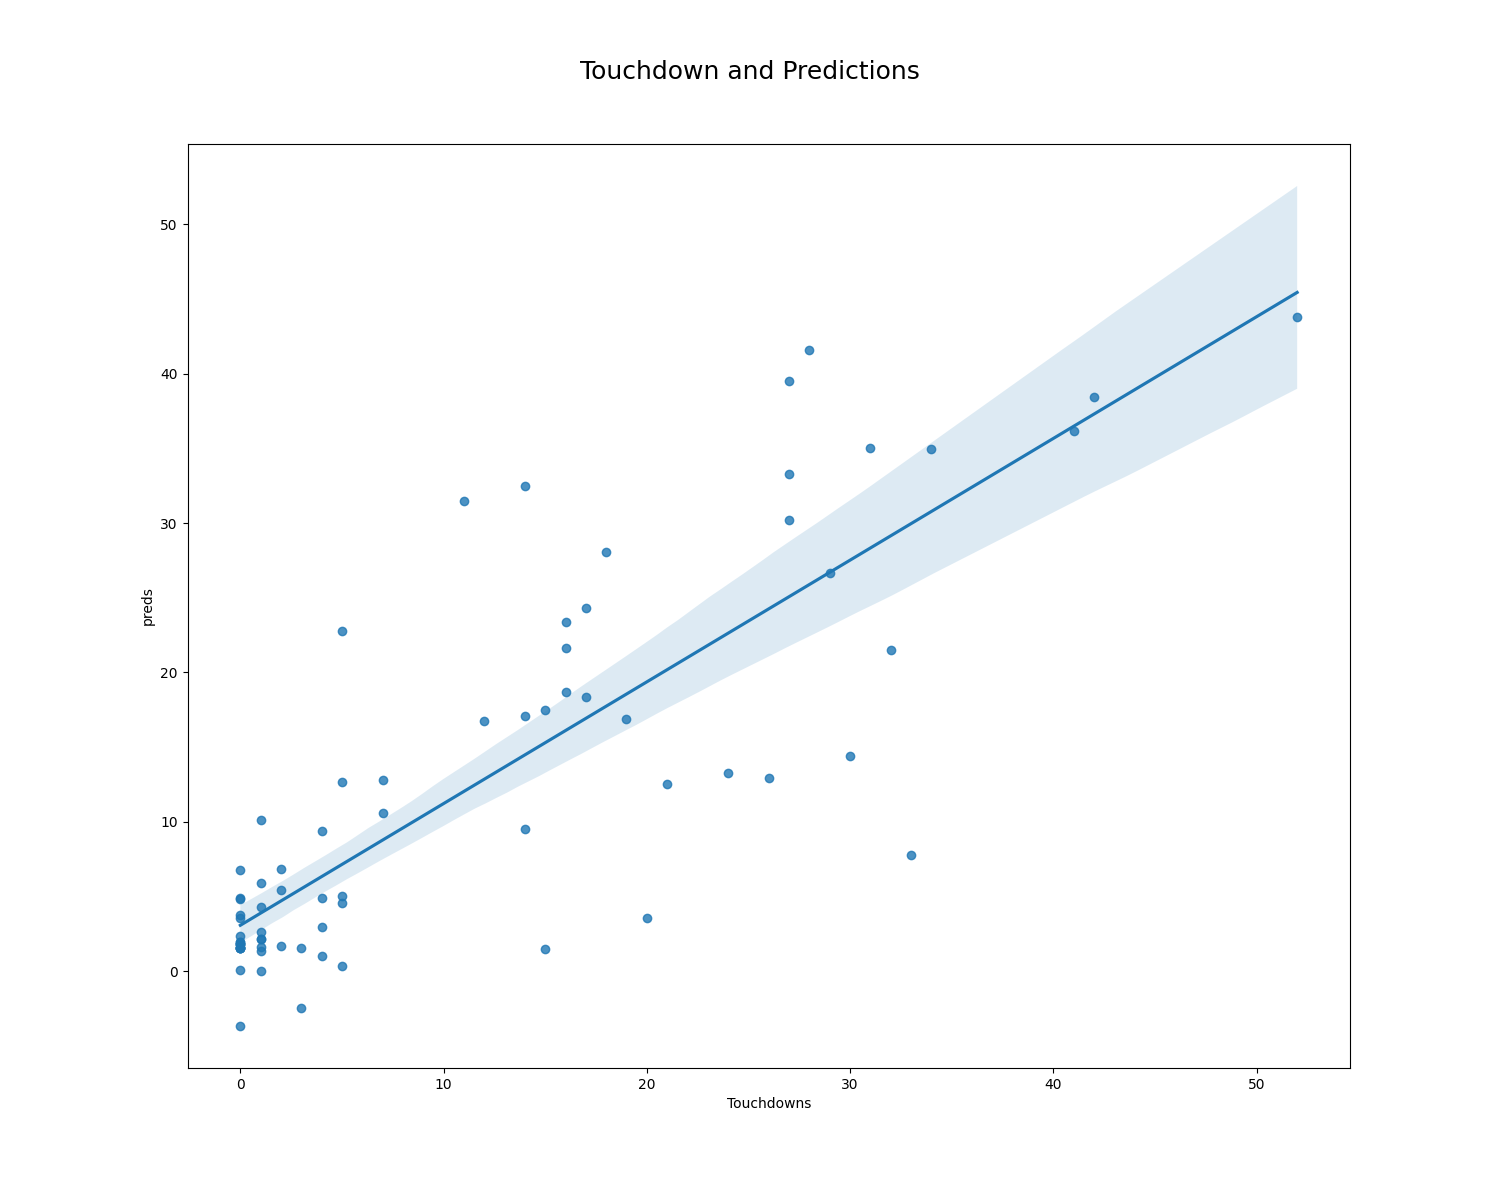

In [89]:
# Let's visualize the outputs 
# sns.regplot(data=test_data, x='touchdown', y='preds')
# plt.title('touchdown and predictions')
# plt.show();
# %matplot plt

# set the plot figure
plt.figure(figsize=(15, 12))
# adjust spacing and set subplots title
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Touchdown and Predictions", fontsize=18, y=0.95)

# set number of columns
ncols = 1
# calculate number of rows
nrows = 1

# add a new subplot iteratively using nrows and cols
ax = plt.subplot(nrows, ncols, 1)
# plot our data
sns.regplot(data=test_data, x='touchdown', y='preds')
# chart formatting
ax.set_xlabel("Touchdowns")

%matplot plt

In [90]:
test_data.loc[:, ['season', 'passer_id', 'passer','touchdown', 'preds']].sort_values('touchdown', ascending=False).head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     season   passer_id      passer  touchdown      preds
296    2022  00-0033873   P.Mahomes       52.0  43.773075
338    2022  00-0036442    J.Burrow       42.0  38.465752
310    2022  00-0034857     J.Allen       41.0  36.171686
262    2022  00-0029604   K.Cousins       34.0  34.953044
265    2022  00-0030565     G.Smith       33.0   7.799100
284    2022  00-0033106      J.Goff       32.0  21.522589
283    2022  00-0033077  D.Prescott       31.0  34.999742
345    2022  00-0036971  T.Lawrence       30.0  14.429281
336    2022  00-0036389     J.Hurts       29.0  26.656970
247    2022  00-0023459   A.Rodgers       28.0  41.606350